## Importation des Données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from PIL import Image

In [ ]:
dataset_path = r"C:\Users\dobel\OneDrive\Bureau\MathsApp\APST2\Celebrity Faces Dataset"

IMG_SIZE = (128, 128)
images = []

for celebrity in os.listdir(dataset_path):
    celebrity_path = os.path.join(dataset_path, celebrity)

    if os.path.isdir(celebrity_path):
        for img_name in os.listdir(celebrity_path):
            img_path = os.path.join(celebrity_path, img_name)

            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
                img = cv2.resize(img, IMG_SIZE)  # Redimensionner à 128x128

                images.append(np.array(img))

            except Exception as e:
                print(f" Erreur en lisant {img_path} : {e}")

images = np.array(images, dtype="float32") / 255.0  # Normalisation [0,1]

print(f"Nombre total d'images : {images.shape[0]}")


✅ Chargement terminé ! Nombre total d'images : 1800


In [ ]:
# Data Augmentation
import cv2
import random

def augmenter_image(image):
    """ Applique une transformation aléatoire sur une image. """
    if random.random() > 0.5:
        image = cv2.flip(image, 1)  # Flip horizontal
    if random.random() > 0.5:
        angle = random.randint(-10, 10)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        image = cv2.warpAffine(image, M, (w, h))
    return image

# Générer 30 versions différentes des images originales
augmented_images = []
for _ in range(30):  
    for img in images:
        augmented_images.append(augmenter_image(img))

# Convertir en numpy array
augmented_images = np.array(augmented_images)

print(f"Nouveau dataset généré de tailles : {augmented_images.shape}")


✅ Nouveau dataset généré avec augmentation ! Taille : (54000, 128, 128, 3)


## Création du réseaux de neuronnes pour VAE

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Paramètres globaux
input_shape = (128, 128, 3)  # Dimensions des images
latent_dim = 32  # Taille de l'espace latent

# Définition de la couche d'échantillonnage
class Sampling(layers.Layer):
    """Utilise (z_mean, z_log_var) pour échantillonner un vecteur latent `z`."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))  # Bruit aléatoire
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Réparamétrisation

# Construction de l'encodeur
encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Construction du décodeur
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", activation="sigmoid")(x)

# Décodeur final
decoder = keras.Model(latent_inputs, x, name="decoder")
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_32[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 32, 32,    │     18,496 │ conv2d_55[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 16, 16,    │     73,856 │ conv2d_56[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 32768)     │          0 │ conv2d_57[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 128)       │  4,194,432 │ flatten_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 64)        │      8,256 │ dense_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 32)        │      2,080 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 32)        │      2,080 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_16         │ (None, 32)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,300,096 (16.40 MB)

 Trainable params: 4,300,096 (16.40 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32768)          │     1,081,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_49             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_50             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_51             │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,220,643 (4.66 MB)

 Trainable params: 1,220,643 (4.66 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
from keras import ops

class VAE(keras.Model): # VAE hérite donc de keras.Model (pemet d'utiliser des fonctionnalités commes .fit ou .compile) 
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs) # Appelle le constructeur de keras.Model
        self.encoder = encoder # l'encodeur
        self.decoder = decoder # le décodeur
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss") #perte total
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        ) # perte de reconstruction
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss") # Divergence LK

    @property # Permet d'accéder aux métriques commen une variable (vae.metrics)
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data): # Remplace le .fit() de Keras
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) #encodeur transforme l'image en un espace latent (loi normale)
            reconstruction = self.decoder(z) #décoder l'image
            reconstruction_loss = ops.mean(ops.sum(ops.abs(data - reconstruction),axis=(1, 2, 3)))
            #reconstruction_loss = ops.mean(ops.sum(keras.losses.binary_crossentropy(data, reconstruction),axis=(1, 2),))

             # compare les pixels entre l'image d'origine et reconstruite
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var)) # Divergence KL
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights) # calcul les gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights)) # met à jour les poids
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(augmented_images, epochs=30, batch_size=128)

Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 122s 276ms/step - kl_loss: 50.4739 - loss: 10055.4873 - reconstruction_loss: 10005.0117
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 114s 269ms/step - kl_loss: 93.0648 - loss: 6227.0317 - reconstruction_loss: 6133.9673
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 114s 269ms/step - kl_loss: 102.7221 - loss: 5372.6338 - reconstruction_loss: 5269.9111
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 114s 269ms/step - kl_loss: 106.0102 - loss: 4943.9546 - reconstruction_loss: 4837.9443
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 111s 262ms/step - kl_loss: 108.3785 - loss: 4639.5723 - reconstruction_loss: 4531.1938
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 113s 267ms/step - kl_loss: 110.4955 - loss: 4430.0405 - reconstruction_loss: 4319.5444
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 113s 267ms/step - kl_loss: 111.7161 - loss: 4278.4619 - reconstruction_loss: 4166.7451
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 112s 265ms/step - kl_loss: 112.6883 - loss: 4178.5454 - reconstruction_

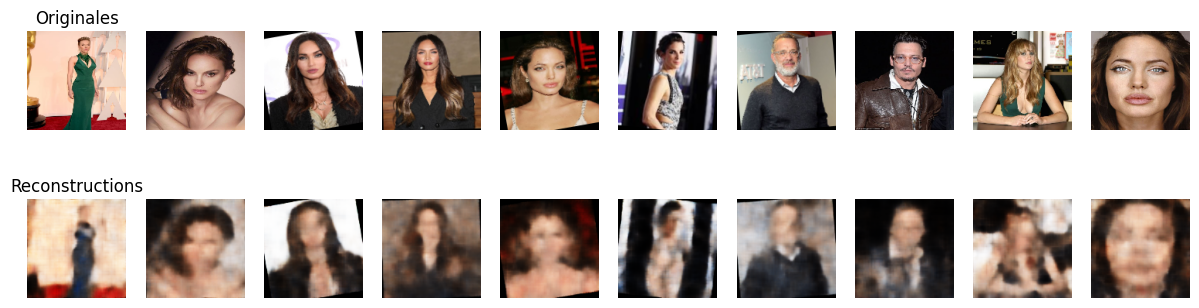

In [ ]:
def plot_reconstruction(model, images, num_images=10):
    indices = np.random.randint(0, images.shape[0], num_images)
    sample_images = images[indices]

    # Passer les images dans l'encodeur pour obtenir z
    z_mean, _, z = model.encoder(sample_images)

    # Passer z dans le décodeur pour reconstruire les images
    reconstructed_images = model.decoder(z)

    # Affichage des images originales vs reconstruites
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 1.5, 4))

    for i in range(num_images):
        # Image originale
        axes[0, i].imshow(sample_images[i])
        axes[0, i].axis("off")

        # Image reconstruite
        axes[1, i].imshow(reconstructed_images[i].numpy())
        axes[1, i].axis("off")

    axes[0, 0].set_title("Originales")
    axes[1, 0].set_title("Reconstructions")
    plt.show()

plot_reconstruction(vae, augmented_images, num_images=10)